In [54]:
#Base
import itertools as iter
import os
import re
import math
import numpy as np
import random as rd


# data eng
import h3
from shapely import geometry
import geopandas as gpd
import pandas as pd
import rioxarray as rx
import osmnx as ox
# import ibis as ib
# import polars as pl

# module
import scale_down as sd

### Visualisation related
from IPython.display import display
import ipywidgets
import contextily as cx
import pydeck as pdk
from matplotlib import pyplot as plt
import seaborn as sns
import pypalettes as pypal


## Introduction
This document elaborates on the techniques to downscale geospatial data sets across different resolutions. 

nice blog post: https://strimas.com/post/hexagonal-grids/

point(-0.1275,51.5131)

poly(-0.12496,51.51047,-0.12029,51.51305)


In [55]:
from s2 import s2
import h3
from shapely import Point, Polygon
import shapely as shp

In [56]:
def make_poly(x_min,y_min,x_max,y_max):
    return Polygon([(x_min,y_min),(x_max,y_min),(x_max,y_max,),(x_min,y_max)])

In [57]:
# x = 51.5119
# y = -0.1227

x_1 = -0.12496
x_2 = -0.12029
y_1 = 51.51047
y_2 = 51.51305


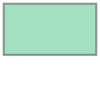

In [58]:
square = make_poly(x_1,y_1,x_2,y_2)
square


In [59]:
y,x = square.centroid.x,square.centroid.y


In [60]:
# res_s2 = 14

# s2_cell = s2.geo_to_s2(lat=y,lon=x,res=res_s2)
# s2_cell_coords = s2.s2_to_geo_boundary(s2_cell)
# s2_cell_geo = Polygon(s2_cell_coords)


In [61]:
print(x,y)

51.51176 -0.12262499999999998


In [62]:
res_h3 = 11

h3_cell = h3.latlng_to_cell(lng=y,lat=x,res=res_h3)
h3_geo = h3.cells_to_h3shape([h3_cell])
h3_geo

<H3Poly: [6]>

In [63]:
gpd.GeoSeries([h3_geo,square],crs="EPSG:4326").explore()

In [64]:
# relative neighbors

i_range = range(-4,4)
j_range = range(-4,4)

coords = [(i,j) for i in i_range for j in j_range]

ref_cell = h3.cell_to_local_ij(origin=h3_cell,h=h3_cell)

# coords
neighbs = [h3.local_ij_to_cell(origin=h3_cell,i=ref_cell[0] + id[0],j=ref_cell[1] + id[1]) for id in coords]
neighbs

['8b194ad3245efff',
 '8b194ad324edfff',
 '8b194ad324e8fff',
 '8b194ad324eafff',
 '8b194ad324c1fff',
 '8b194ad324c3fff',
 '8b194ad324dcfff',
 '8b194ad324defff',
 '8b194ad32451fff',
 '8b194ad32453fff',
 '8b194ad324ecfff',
 '8b194ad324eefff',
 '8b194ad324c5fff',
 '8b194ad324c0fff',
 '8b194ad324c2fff',
 '8b194ad324d1fff',
 '8b194ad32455fff',
 '8b194ad32450fff',
 '8b194ad32452fff',
 '8b194ad324e1fff',
 '8b194ad324e3fff',
 '8b194ad324c4fff',
 '8b194ad324c6fff',
 '8b194ad324d5fff',
 '8b194ad32473fff',
 '8b194ad32454fff',
 '8b194ad32456fff',
 '8b194ad324e5fff',
 '8b194ad324e0fff',
 '8b194ad324e2fff',
 '8b194ad324f1fff',
 '8b194ad324f3fff',
 '8b194ad32470fff',
 '8b194ad32472fff',
 '8b194ad32409fff',
 '8b194ad3240bfff',
 '8b194ad324e4fff',
 '8b194ad324e6fff',
 '8b194ad324f5fff',
 '8b194ad324f0fff',
 '8b194ad32474fff',
 '8b194ad32476fff',
 '8b194ad3240dfff',
 '8b194ad32408fff',
 '8b194ad3240afff',
 '8b194ad32419fff',
 '8b194ad3241bfff',
 '8b194ad324f4fff',
 '8b194ad3255afff',
 '8b194ad32429fff',


In [65]:
ref_cell[0]

-5681

In [66]:
neighbs_geo = h3.cells_to_h3shape(neighbs)

In [67]:
# relative coordinates coordinates of the neighbors if approximating the shape with the h3 function 

neighbs = [h3.cell_to_local_ij(origin=h3_cell,h=cell) for cell in h3.geo_to_cells(square,res=11)] 

neighb_id= [(neighb[0]-ref_cell[0],neighb[1]-ref_cell[1]) for neighb in neighbs]


In [128]:
neighb_id

[(-2, -4),
 (3, 4),
 (-2, -2),
 (2, 1),
 (2, 3),
 (0, -3),
 (-1, 1),
 (-1, 3),
 (3, 1),
 (-1, -1),
 (-2, 1),
 (0, 3),
 (2, 0),
 (0, -1),
 (0, -2),
 (1, -1),
 (0, 0),
 (2, -1),
 (-3, -1),
 (-3, 2),
 (-2, -1),
 (-1, 2),
 (-3, 0),
 (2, -2),
 (1, 3),
 (3, -2),
 (-1, -3),
 (-3, -4),
 (2, 4),
 (2, 2),
 (3, 2),
 (1, 1),
 (1, 2),
 (1, -3),
 (0, 2),
 (3, 3),
 (-2, 2),
 (1, -2),
 (-3, 1),
 (-3, -2),
 (-2, -3),
 (1, 0),
 (0, 1),
 (-3, -3),
 (-2, 0),
 (3, 0),
 (-1, -2),
 (3, -1),
 (-1, 0)]

### Approximating other shapes with hexes

In [127]:
res_h3 = 11

x = 51.51176 
y = -0.1227

h3_cell = h3.latlng_to_cell(lng=y,lat=x,res=res_h3)
h3_geo = h3.cells_to_h3shape([h3_cell])
h3_geo

gpd.GeoSeries([h3_geo],crs="EPSG:4326").explore() # should show a hex over Covent garden in London

# Getting the ij neighbors h3 ids.

i_range = range(-3,4)
j_range = range(-3,4)

coords = [(i,j) for i in i_range for j in j_range]
# coords
ref_cell = h3.cell_to_local_ij(origin=h3_cell,h=h3_cell)

neighbs = [h3.local_ij_to_cell(origin=h3_cell,i=ref_cell[0]+id[0],j=ref_cell[1]+id[1]) for id in neighb_id]
neighbs
neighbs_geo = h3.cells_to_h3shape(neighbs)

# plots in the Atlantic Ocean
gpd.GeoSeries([h3_geo,neighbs_geo,square],crs="EPSG:4326").explore()


### Naive approach

In [69]:

def plot_df(df, column=None, ax=None):
    'Plot based on the `geometry` column of a GeoPandas dataframe'
    df = df.copy()
    df = df.to_crs(epsg=3857) # web mercator

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    df.plot(
        ax=ax,
        alpha=0.5, edgecolor='k',
        column=column, categorical=True,
        legend=True, legend_kwds={'loc': 'upper left'}, 
    )
    cx.add_basemap(ax, crs=df.crs, source=cx.providers.CartoDB.Positron)

def plot_shape(shape, ax=None):
    df = geopandas.GeoDataFrame({'geometry': [shape]}, crs='EPSG:4326')
    plot_df(df, ax=ax)

def plot_cells(cells, ax=None):
    shape = h3.cells_to_h3shape(cells)
    plot_shape(shape, ax=ax)

def plot_shape_and_cells(shape, res=9):
    fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    plot_shape(shape, ax=axs[0])
    plot_cells(h3.h3shape_to_cells(shape, res), ax=axs[1])
    fig.tight_layout()

In [70]:
child_num = 7
res_ = 3

In [71]:
test_grid = [-15.161,0.725,10.371,18.208]

bbox_polygon = geometry.box(*test_grid)
print(bbox_polygon.wkt)

POLYGON ((10.371 0.725, 10.371 18.208, -15.161 18.208, -15.161 0.725, 10.371 0.725))


In [72]:
h3_shape = h3.geo_to_h3shape(bbox_polygon)

In [73]:
h3_shape_cells = h3.h3shape_to_cells(h3_shape,res=res_)

In [74]:
h3_df = pd.DataFrame(pd.Series(h3_shape_cells),columns=["h3_id"],dtype='str')

# with polars
# h3_pl = pl.DataFrame(h3_df)

In [75]:
len(h3_shape_cells)

530

In [76]:
h3_df["geom"] = gpd.GeoSeries(h3_df.h3_id.apply(lambda x: h3.cells_to_h3shape([x])))
h3_df = gpd.GeoDataFrame(h3_df,geometry="geom")

## Data manipulations

adding some randomly sampled data

In [77]:
alpha = 1
h3_df["values_e"] = [rd.expovariate(lambd=2*alpha) for x in h3_df.h3_id]

h3_df["values_i"] = [rd.expovariate(lambd=alpha) for x in h3_df.h3_id]

h3_df = sd.add_geom(h3_df)

In [78]:
h3_df.explore(column="values_e")

In [79]:
h3_df["child"] = h3_df.h3_id.apply(h3.cell_to_children)


In [80]:
h3_df_expl = h3_df[["child","values_i","values_e"]].explode("child").rename(columns={"child":"h3_id"})
h3_df_expl.head()

h3_id  values_i  values_e
0  8454041ffffffff  2.116251  0.150448
0  8454043ffffffff  2.116251  0.150448
0  8454045ffffffff  2.116251  0.150448
0  8454047ffffffff  2.116251  0.150448
0  8454049ffffffff  2.116251  0.150448

In [81]:
h3_df_expl["values_e"] = h3_df_expl[["h3_id","values_e"]].filter(regex="_e").mul({"values_e":1/child_num})

In [82]:
h3_df_expl = sd.add_geom(h3_df_expl)

In [83]:
h3_df_expl.explore(column = "values_e")

In [84]:
osm_admin = ox.geocode_to_gdf(query="Ile de France")
# osm_poly = h3.latlng_to_cell(osm_admin,res=res_)
osm_admin.explore()

In [85]:
osm_df = pd.DataFrame()

In [86]:
osm_cells = osm_admin.geometry.apply(lambda x: h3.geo_to_cells(x,res=6)).explode().reset_index(drop=True)
osm_cells


0      861fb6b4fffffff
1      861fb4607ffffff
2      861fb0ae7ffffff
3      861fb5497ffffff
4      861fb6a6fffffff
            ...       
366    861fb6b07ffffff
367    861fb0197ffffff
368    861fb0a9fffffff
369    861fb6a27ffffff
370    861fb44dfffffff
Name: geometry, Length: 371, dtype: object

In [87]:
osm_df["compact"] = pd.Series(h3.compact_cells(osm_cells),index=None)


In [88]:
osm_df.head()

compact
0  861fb0ae7ffffff
1  861fb636fffffff
2  861fb0307ffffff
3  861fb448fffffff
4  861fb0067ffffff

In [89]:
osm_df["geom"] = osm_df.compact.apply(lambda x: h3.cells_to_h3shape([x]))

osm_df = gpd.GeoDataFrame(osm_df,geometry="geom",crs="EPSG:4326")

In [90]:
osm_df.explore()

### Projecting crops 

In [91]:
mapspam_dir = "/Users/cenv1069/Documents/agriculture/mapspam/spam2017v2r1_ssa_val_prod/"

mapspan_files = os.listdir(mapspam_dir)

In [92]:
mapspam = rx.open_rasterio(mapspam_dir+mapspan_files[0],)

In [93]:
mapspam

<xarray.DataArray (band: 1, y: 2160, x: 4320)> Size: 37MB
[9331200 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 35kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y            (y) float64 17kB 89.96 89.88 89.79 ... -89.79 -89.87 -89.96
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -1.0
    scale_factor:   1.0
    add_offset:     0.0

In [94]:
mapspam_df_ = mapspam[0,:,:].to_pandas().melt(ignore_index=False).reset_index().rename(columns={"value":"value_var"})

In [95]:
mapspam_df_.head()

y           x  value_var
0  89.958333 -179.958334       -1.0
1  89.875000 -179.958334       -1.0
2  89.791667 -179.958334       -1.0
3  89.708334 -179.958334       -1.0
4  89.625001 -179.958334       -1.0

In [96]:
mapspam_df_raw = mapspam_df_[mapspam_df_.value_var>0].reset_index(drop=True)
# mapspam_df = mapspam_df_[mapspam_df_.value_var>0].reset_index(drop=True)

<Axes: >

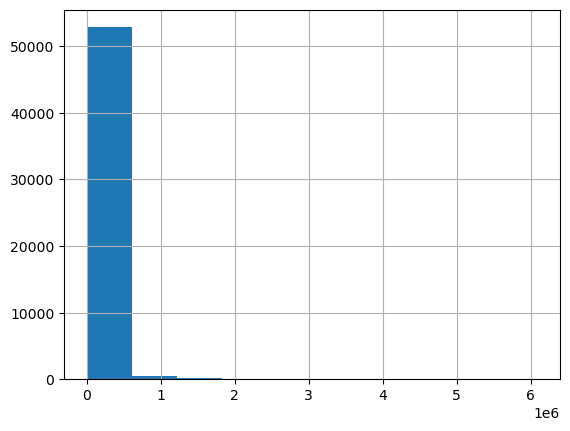

In [97]:
mapspam_df_raw.value_var.hist()

In [98]:
res_crop = 6

In [99]:


# def get_square(h3_cell: str, d: float = 10000):
    
#     h3_d = np.round(np.sqrt(h3.cell_area(h3_cell,unit="m^2")),2)
#     frag = int(np.ceil(d/h3_d))

#     h3_ref = h3.cell_to_local_ij(origin=h3_cell,h=h3_cell)

#     i_range = range(-frag,frag+1)
#     j_range = range(-frag,frag+1)

#     coords = [(i,j) for i in i_range for j in j_range]
#     # coords
#     ref_cell = h3.cell_to_local_ij(origin=h3_cell,h=h3_cell)

#     return [h3.local_ij_to_cell(origin=h3_cell,i=ref_cell[0]+id[0],j=ref_cell[1]+id[1]) for id in coords]


In [100]:
mapspam_df_raw.head()

y          x     value_var
0  13.375306 -16.792319   3647.500000
1  13.291973 -16.792319  11340.200195
2  14.291969 -16.708987     63.299999
3  14.208636 -16.708987    189.699997
4  14.125303 -16.708987    253.000000

In [101]:
# get_square("8854a93225fffff")

In [102]:
mapspam_df_raw["geom"] = mapspam_df_raw.filter(regex="h3_id_").apply(h3.cells_to_h3shape)

mapspam_gdf = gpd.GeoDataFrame(mapspam_df
                               ,geometry="geom"
                               ,crs="EPSG:4326")

mapspam_gdf.iloc[0:100].explore(column="value")
mapspam_gdf.head()

In [103]:
try : mapspam_df_raw.drop(labels=["h3_id"],axis={0},inplace=True)
except : Warning("Nothing to remove, skipping")
mapspam_df_raw["h3_id"] = mapspam_df_raw.apply(lambda row: h3.latlng_to_cell(row["y"],row["x"],res=res_crop),axis=1)
mapspam_df_raw

y          x     value_var  geom            h3_id
0      13.375306 -16.792319   3647.500000   NaN  8654a9337ffffff
1      13.291973 -16.792319  11340.200195   NaN  8654a931fffffff
2      14.291969 -16.708987     63.299999   NaN  8654ad387ffffff
3      14.208636 -16.708987    189.699997   NaN  8654ad2a7ffffff
4      14.125303 -16.708987    253.000000   NaN  8654ad2afffffff
...          ...        ...           ...   ...              ...
53675 -15.124580  50.374078   5349.899902   NaN  86a356ae7ffffff
53676 -15.207913  50.374078   3143.100098   NaN  86a356ad7ffffff
53677 -15.291246  50.374078     66.900002   NaN  86a35632fffffff
53678 -15.207913  50.457412   1604.900024   NaN  86a356acfffffff
53679 -15.291246  50.457412    334.299988   NaN  86a356367ffffff

[53680 rows x 5 columns]

In [104]:
mapspam_df = mapspam_df_raw[["h3_id","value_var"]].groupby("h3_id").agg("sum").reset_index()
mapspam_df

h3_id     value_var
0      865280477ffffff    590.099976
1      865280807ffffff   1376.800049
2      86528080fffffff    524.500000
3      8652808c7ffffff   1311.199951
4      8652808d7ffffff   1901.199951
...                ...           ...
53675  86bcf6acfffffff   3186.600098
53676  86bcf6ad7ffffff  11059.299805
53677  86bcf6adfffffff   5748.299805
53678  86bcf6ae7ffffff    874.700012
53679  86bcf6aefffffff    312.399994

[53680 rows x 2 columns]

In [105]:
compact_geo = sd.add_geom(mapspam_df)

In [106]:
compact_geo.shape

(53680, 3)

In [107]:
compact_geo["log_value_var"] = np.round(np.log1p(compact_geo["value_var"]))

In [108]:
compact_geo.head()

h3_id    value_var  \
0  865280477ffffff   590.099976   
1  865280807ffffff  1376.800049   
2  86528080fffffff   524.500000   
3  8652808c7ffffff  1311.199951   
4  8652808d7ffffff  1901.199951   

                                                geom  log_value_var  
0  POLYGON ((38.27947 12.86167, 38.29737 12.83463...            6.0  
1  POLYGON ((38.5914 13.4915, 38.57351 13.51876, ...            7.0  
2  POLYGON ((38.5914 13.4915, 38.57484 13.46133, ...            6.0  
3  POLYGON ((38.57751 13.34657, 38.59536 13.31938...            7.0  
4  POLYGON ((38.57751 13.34657, 38.5431 13.34362,...            8.0

In [109]:
compact_geo.loc[0:1000].explore(column="log_value_var")

In [110]:
compact_geo

h3_id     value_var  \
0      865280477ffffff    590.099976   
1      865280807ffffff   1376.800049   
2      86528080fffffff    524.500000   
3      8652808c7ffffff   1311.199951   
4      8652808d7ffffff   1901.199951   
...                ...           ...   
53675  86bcf6acfffffff   3186.600098   
53676  86bcf6ad7ffffff  11059.299805   
53677  86bcf6adfffffff   5748.299805   
53678  86bcf6ae7ffffff    874.700012   
53679  86bcf6aefffffff    312.399994   

                                                    geom  log_value_var  
0      POLYGON ((38.27947 12.86167, 38.29737 12.83463...            6.0  
1      POLYGON ((38.5914 13.4915, 38.57351 13.51876, ...            7.0  
2      POLYGON ((38.5914 13.4915, 38.57484 13.46133, ...            6.0  
3      POLYGON ((38.57751 13.34657, 38.59536 13.31938...            7.0  
4      POLYGON ((38.57751 13.34657, 38.5431 13.34362,...            8.0  
...                                                  ...            ...  
53675  POLYGON ((32.1688 -28.49567, 32.18347 -28.4635...            8.0  
53676  POLYGON ((32.28837 -28.47869, 32.30303 -28.446...            9.0  
53677  POLYGON ((32.18347 -28.46359, 32.22333 -28.457...            9.0  
53678  POLYGON ((32.2045 -28.58056, 32.24438 -28.5749...            7.0  
53679  POLYGON ((32.1688 -28.49567, 32.12893 -28.5013...            6.0  

[53680 rows x 4 columns]

In [112]:
compact_geo_downscaled = sd.change_scale(grid=compact_geo, level=-3)
compact_geo_downscaled["log_value_var"] = np.round(np.log1p(compact_geo_downscaled["value_var"]),decimals=2)
compact_geo_downscaled

Skipping geom


h3_id                                        child_cells  \
0    835280fffffffff  [8452805ffffffff, 8452809ffffffff, 845280dffff...   
1    835282fffffffff  [8452821ffffffff, 8452823ffffffff, 8452825ffff...   
2    835283fffffffff  [8452831ffffffff, 8452835ffffffff, 8452837ffff...   
3    835284fffffffff  [8452841ffffffff, 8452843ffffffff, 8452845ffff...   
4    835285fffffffff                 [8452853ffffffff, 845285dffffffff]   
..               ...                                                ...   
948  83bcf2fffffffff  [84bcf21ffffffff, 84bcf23ffffffff, 84bcf25ffff...   
949  83bcf3fffffffff  [84bcf31ffffffff, 84bcf35ffffffff, 84bcf39ffff...   
950  83bcf4fffffffff                 [84bcf43ffffffff, 84bcf47ffffffff]   
951  83bcf5fffffffff  [84bcf51ffffffff, 84bcf53ffffffff, 84bcf55ffff...   
952  83bcf6fffffffff  [84bcf63ffffffff, 84bcf67ffffffff, 84bcf6bffff...   

        value_var  log_value_var  
0    4.969470e+04          10.81  
1    1.189984e+06          13.99  
2    3.338324e+05          12.72  
3    1.562956e+06          14.26  
4    1.291540e+04           9.47  
..            ...            ...  
948  8.083078e+05          13.60  
949  2.463895e+05          12.41  
950  1.360227e+05          11.82  
951  2.434266e+05          12.40  
952  1.067185e+05          11.58  

[953 rows x 4 columns]

In [113]:
max_geom = np.min([50_000,compact_geo_downscaled.shape[0]])

compact_geo_downscaled_sub = sd.add_geom(compact_geo_downscaled.loc[0:max_geom].copy())

compact_geo_downscaled_sub.reset_index(drop=True,inplace=True)

compact_geo_downscaled_sub

h3_id                                        child_cells  \
0    835280fffffffff  [8452805ffffffff, 8452809ffffffff, 845280dffff...   
1    835282fffffffff  [8452821ffffffff, 8452823ffffffff, 8452825ffff...   
2    835283fffffffff  [8452831ffffffff, 8452835ffffffff, 8452837ffff...   
3    835284fffffffff  [8452841ffffffff, 8452843ffffffff, 8452845ffff...   
4    835285fffffffff                 [8452853ffffffff, 845285dffffffff]   
..               ...                                                ...   
948  83bcf2fffffffff  [84bcf21ffffffff, 84bcf23ffffffff, 84bcf25ffff...   
949  83bcf3fffffffff  [84bcf31ffffffff, 84bcf35ffffffff, 84bcf39ffff...   
950  83bcf4fffffffff                 [84bcf43ffffffff, 84bcf47ffffffff]   
951  83bcf5fffffffff  [84bcf51ffffffff, 84bcf53ffffffff, 84bcf55ffff...   
952  83bcf6fffffffff  [84bcf63ffffffff, 84bcf67ffffffff, 84bcf6bffff...   

        value_var  log_value_var  \
0    4.969470e+04          10.81   
1    1.189984e+06          13.99   
2    3.338324e+05          12.72   
3    1.562956e+06          14.26   
4    1.291540e+04           9.47   
..            ...            ...   
948  8.083078e+05          13.60   
949  2.463895e+05          12.41   
950  1.360227e+05          11.82   
951  2.434266e+05          12.40   
952  1.067185e+05          11.58   

                                                  geom  
0    POLYGON ((37.97019 12.83405, 38.46072 12.47793...  
1    POLYGON ((37.27428 11.9689, 37.76603 11.61796,...  
2    POLYGON ((38.35619 11.87175, 38.83967 11.52114...  
3    POLYGON ((38.07384 13.44699, 38.67299 13.69993...  
4    POLYGON ((39.75747 13.58785, 39.8701 14.19935,...  
..                                                 ...  
948  POLYGON ((32.7036 -27.72632, 32.73102 -27.0861...  
949  POLYGON ((31.4156 -27.69724, 31.44691 -27.0565...  
950  POLYGON ((32.01551 -28.66712, 31.35241 -28.967...  
951  POLYGON ((30.72063 -28.6327, 30.05488 -28.9271...  
952  POLYGON ((32.7036 -27.72632, 32.04515 -28.0321...  

[953 rows x 5 columns]

In [114]:
# compact_geo.to_file("outputs/compact_geo.geojson")

In [115]:
mapspam_df

h3_id     value_var  \
0      865280477ffffff    590.099976   
1      865280807ffffff   1376.800049   
2      86528080fffffff    524.500000   
3      8652808c7ffffff   1311.199951   
4      8652808d7ffffff   1901.199951   
...                ...           ...   
53675  86bcf6acfffffff   3186.600098   
53676  86bcf6ad7ffffff  11059.299805   
53677  86bcf6adfffffff   5748.299805   
53678  86bcf6ae7ffffff    874.700012   
53679  86bcf6aefffffff    312.399994   

                                                    geom  
0      POLYGON ((38.27947 12.86167, 38.29737 12.83463...  
1      POLYGON ((38.5914 13.4915, 38.57351 13.51876, ...  
2      POLYGON ((38.5914 13.4915, 38.57484 13.46133, ...  
3      POLYGON ((38.57751 13.34657, 38.59536 13.31938...  
4      POLYGON ((38.57751 13.34657, 38.5431 13.34362,...  
...                                                  ...  
53675  POLYGON ((32.1688 -28.49567, 32.18347 -28.4635...  
53676  POLYGON ((32.28837 -28.47869, 32.30303 -28.446...  
53677  POLYGON ((32.18347 -28.46359, 32.22333 -28.457...  
53678  POLYGON ((32.2045 -28.58056, 32.24438 -28.5749...  
53679  POLYGON ((32.1688 -28.49567, 32.12893 -28.5013...  

[53680 rows x 3 columns]

### Color palette

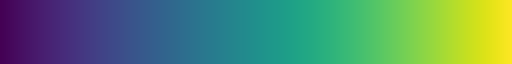

In [116]:
viridis = sns.color_palette("viridis", as_cmap=True)
viridis

In [117]:
bmlunge = pypal.load_cmap("Bmlunge")
bmlunge.N

6

In [118]:
def cmap(input, palette):
    m = np.max(input.to_list())
    l = palette.N
    print("Max input : {}, palette colors : {}".format(m,l))
    return [[int(255*j) for j in palette(int(x/m*l))] for x in input] #

In [119]:
unique_vals = pd.Series(compact_geo_downscaled["log_value_var"].unique())
unique_vals

0      10.81
1      13.99
2      12.72
3      14.26
4       9.47
       ...  
625    14.07
626     7.60
627     8.21
628    12.41
629    11.58
Length: 630, dtype: float32

In [120]:
cols =  cmap(compact_geo_downscaled_sub["log_value_var"],palette=bmlunge) #pd.Series([[255*j for j in x] for x in bmlunge(compact_geo_downscaled["log_value"])])
compact_geo_downscaled_sub["color"] = cols
compact_geo_downscaled_sub.head()
# print(cols)
# print(unique_vals)

Max input : 18.690000534057617, palette colors : 6


h3_id                                        child_cells  \
0  835280fffffffff  [8452805ffffffff, 8452809ffffffff, 845280dffff...   
1  835282fffffffff  [8452821ffffffff, 8452823ffffffff, 8452825ffff...   
2  835283fffffffff  [8452831ffffffff, 8452835ffffffff, 8452837ffff...   
3  835284fffffffff  [8452841ffffffff, 8452843ffffffff, 8452845ffff...   
4  835285fffffffff                 [8452853ffffffff, 845285dffffffff]   

      value_var  log_value_var  \
0  4.969470e+04          10.81   
1  1.189984e+06          13.99   
2  3.338324e+05          12.72   
3  1.562956e+06          14.26   
4  1.291540e+04           9.47   

                                                geom                color  
0  POLYGON ((37.97019 12.83405, 38.46072 12.47793...  [52, 170, 182, 255]  
1  POLYGON ((37.27428 11.9689, 37.76603 11.61796,...  [61, 118, 136, 255]  
2  POLYGON ((38.35619 11.87175, 38.83967 11.52114...  [61, 118, 136, 255]  
3  POLYGON ((38.07384 13.44699, 38.67299 13.69993...  [61, 118, 136, 255]  
4  POLYGON ((39.75747 13.58785, 39.8701 14.19935,...  [52, 170, 182, 255]

In [121]:
# viewport = pdk.data_utils.compute_view(points=compact_geo_downscaled[['x', 'y']], view_proportion=0.9)
viewport = pdk.ViewState(longitude=0,latitude=0,zoom=3)
# auto_zoom_map = pdk.Deck(layers=[], initial_view_state=viewport)
# auto_zoom_map.show()

In [122]:

# scaled_layer = pdk.Layer(
#     "GeoJsonLayer",
#     compact_geo_downscaled_sub,
#     pickable=True,
#     extruded=False,
#     filled=True,
#     stroked=True,
#     opacity=.6,
#     get_geometry = "geom",
#     get_fill_color = "color", #"[255*log_value/20,100,120]",
#     get_line_color= [255, 255, 255, 0],
#     line_width_min_pixels=1,
#     )

h3_layer = pdk.Layer(
    "H3HexagonLayer",
    compact_geo_downscaled_sub,
    pickable=True,
    stroked=True,
    filled=True,
    opacity=.5,
    extruded=False,
    get_hexagon="h3_id",
    get_fill_color= "color",
    get_line_color=[0, 0, 0, 0],
    line_width_min_pixels=1,
)

# raster_centr_layer = pdk.Layer(
#     "ScatterplotLayer",
#     mapspam_df_raw,
#     pickable=True,
#     opacity=0.3,
#     stroked=True,
#     filled=True,
#     radius_scale=1,
#     radius_min_pixels=4,
#     radius_max_pixels=5,
#     line_width_min_pixels=1,
#     get_position=["x","y"],
#     get_radius=5,
#     get_fill_color=[255, 140, 0],
#     get_line_color=[0, 0, 0, 0],
# )

r = pdk.Deck(layers=[h3_layer]
            ,initial_view_state=viewport,tooltip=True)

# h3_layer

# Create an HTML header to display the year
# display_el = ipywidgets.HTML('<h1>Cropland in Sub-Saharan africa</h1>')
# display(display_el)
# Show the current visualization
# r.show()


In [123]:
r.to_html("deck_maps/cropland_downscaled.html",iframe_height=600)

## Algorightm ameliorations

In [124]:

# meters
# resolution of the grid for rasters, 0 otherwise
orig_grid_d = 10000

we want to keep the radius of the boundary cells below the 'radius' of the original grid

for a given resolution, we only keep cells that are whithin orig_grid_d/2 from the centroids of the raster.

In [125]:
h_r = np.sqrt(8/3/np.sqrt(3))
h3_d = np.sqrt(compact_geo.h3_id.apply(h3.cell_area,unit='m^2').mean())*h_r

print(h3_d)
k_res= #int(np.ceil(orig_grid_d/h3_d/2))
k_res

SyntaxError: invalid syntax (2069404270.py, line 5)

In [ ]:
k_rings = pd.Series(compact_geo.h3_id.apply(h3.grid_disk,k=k_res),name="k_rings")
k_rings

0        [8852804769fffff, 8852804297fffff, 885280476df...
1        [8852808027fffff, 8852808025fffff, 885280811bf...
2        [8852808095fffff, 8852808083fffff, 88528080b9f...
3        [8852808c59fffff, 8852808e37fffff, 8852808c5df...
4        [8852808d25fffff, 8852801253fffff, 8852801219f...
                               ...                        
53675    [88bcf6acbbfffff, 88bcf6acb9fffff, 88bcf6acb1f...
53676    [88bcf6ad69fffff, 88bcf6a897fffff, 88bcf6ad6df...
53677    [88bcf6adc9fffff, 88bcf6ac27fffff, 88bcf6adcdf...
53678    [88bcf6ae39fffff, 88bcf6ae07fffff, 88bcf6ae3df...
53679    [88bcf6af49fffff, 88bcf6a1a7fffff, 88bcf6af4df...
Name: k_rings, Length: 53680, dtype: object

In [ ]:
compact_geo["k_ring"] = k_rings


In [ ]:
compact_k_rings = pd.DataFrame(h3.compact_cells(k_rings.explode().unique().tolist()),columns=["h3_id"])

In [ ]:
compact_k_rings_geo = sd.add_geom(compact_k_rings)

In [ ]:
compact_k_rings_geo.shape

(795110, 2)

In [ ]:
compact_k_rings_geo_sub = compact_k_rings_geo.loc[0:400000]
compact_k_rings_geo_sub.head()

h3_id                                               geom
0  88528042c3fffff  POLYGON ((38.25857 12.90892, 38.25623 12.90462...
1  88528042c7fffff  POLYGON ((38.24897 12.89989, 38.25153 12.89602...
2  88528042ebfffff  POLYGON ((38.25153 12.89602, 38.24897 12.89989...
3  88528042e3fffff  POLYGON ((38.2445 12.88312, 38.2494 12.88355, ...
4  8852804089fffff  POLYGON ((38.2654 12.83588, 38.26774 12.84018,...

In [ ]:
# SAVING LOCALLY, plot in Qgis

compact_k_rings_geo.to_file("outputs/compact_k_rings.geojson")

### MAP

In [ ]:
# viewport = pdk.data_utils.compute_view(points=compact_geo_downscaled[['x', 'y']], view_proportion=0.9)
viewport = pdk.ViewState(longitude=0,latitude=0,zoom=3)
auto_zoom_map = pdk.Deck(layers=[], initial_view_state=viewport)
# auto_zoom_map.show()

In [ ]:

# h3_layer2 = pdk.Layer(
#     "H3HexagonLayer",
#     compact_k_rings_geo_sub,
#     pickable=True,
#     stroked=True,
#     filled=True,
#     opacity=.5,
#     extruded=False,
#     get_hexagon="h3_id",
#     get_fill_color= [255,0,0,255],
#     get_line_color=[0, 0, 0, 0],
#     line_width_min_pixels=1,
# )


# scaled_layer2 = pdk.Layer(
#     "GeoJsonLayer",
#     compact_k_rings_geo_sub,
#     pickable=True,
#     extruded=False,
#     filled=True,
#     stroked=True,
#     opacity=.6,
#     get_geometry = "geom",
#     get_fill_color =  [255,0,0,255],
#     get_line_color= [255, 255, 255, 0],
#     line_width_min_pixels=1,
#     )


# raster_centr_layer = pdk.Layer(
#     "ScatterplotLayer",
#     mapspam_df_raw,
#     pickable=True,
#     opacity=0.3,
#     stroked=True,
#     filled=True,
#     radius_scale=5,
#     radius_min_pixels=2,
#     radius_max_pixels=15,
#     line_width_min_pixels=1,
#     get_position=["x","y"],
#     get_radius=30,
#     get_fill_color=[255, 140, 0],
#     get_line_color=[0, 0, 0, 0],
# )

# r2 = pdk.Deck(layers=[scaled_layer2
#                     #  ,raster_centr_layer
#                      ]
#             ,initial_view_state=viewport,tooltip=True)


In [ ]:
# r2.to_html("deck_maps/cropland_downscaled_2.html")